In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import matplotlib.pyplot as plt
import os, sys
import time
%matplotlib inline

os.chdir('..\..\..\..')

# from input_configuration import base_year
import toml
config = toml.load(os.path.join(os.getcwd(), 'configuration/input_configuration.toml'))

from IPython.display import display, HTML

if (sys.version_info < (3, 0)):
    HTML('''<script>
    code_show=true; 
    function code_toggle() {
     if (code_show){
     $('div.input').hide();
     } else {
     $('div.input').show();
     }
     code_show = !code_show
    } 
    $( document ).ready(code_toggle);
    </script>
    <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')



In [2]:
# Create timestamp to show when this summary was run
print('Summary run: ' + time.strftime("%a, %d %b %Y %H:%M"))

Summary run: Wed, 27 Nov 2024 10:22


In [3]:
working_dir = r'outputs/agg/dash'
pd.options.display.float_format = '{:0,.0f}'.format
format_percent = "{:,.1%}".format

# Workers by County

In [4]:
df_wfh = pd.read_csv(os.path.join(working_dir,'wfh_county.csv'))
df_wfh_survey = pd.read_csv(os.path.join(working_dir,'survey','wfh_county.csv'))

# Total Workers by County
df_tot = pd.read_csv(os.path.join(working_dir,'pptyp_county.csv'))
df_tot = df_tot[df_tot['pptyp'].isin(['Full-Time Worker', 'Part-Time Worker'])]
df_tot = df_tot.groupby('person_county').sum()[['psexpfac']].reset_index()
total_nonwfh_workers = df_tot.sum()['psexpfac']

df_tot_survey = pd.read_csv(os.path.join(working_dir,'survey','pptyp_county.csv'))
df_tot_survey = df_tot_survey[df_tot_survey['pptyp'].isin(['Full-Time Worker', 'Part-Time Worker'])]
df_tot_survey = df_tot_survey.groupby('person_county').sum()[['psexpfac']].reset_index()
total_nonwfh_workers_survey = df_tot_survey.sum()['psexpfac']

df = df_wfh.merge(df_tot, on='person_county')
df.index = df['person_county']
df.drop('person_county', axis=1,inplace=True)
df.columns = ['WFH Workers', 'Total Workers']
df.loc['Region'] = df.sum(axis=0)
df['% WFH Workers'] = (df['WFH Workers']/df['Total Workers']).apply(format_percent)
df

,WFH Workers,Total Workers,% WFH Workers
person_county,,,
King,"150,005","1,217,002",12.3%
Kitsap,"18,288","118,562",15.4%
Pierce,"56,596","425,806",13.3%
Snohomish,"56,146","420,762",13.3%
Region,"281,035","2,182,132",12.9%


# Tour Rate for Work-at-Home Workers

In [5]:
df_tours = pd.read_csv(os.path.join(working_dir,'work_from_home_tours.csv'))
total_wfh_workers = df_wfh.psexpfac.sum()
df = df_tours.groupby('pdpurp').sum()[['toexpfac']].reset_index()
df['tour_rate'] = df['toexpfac']/total_wfh_workers
df

df_tours_survey = pd.read_csv(os.path.join(working_dir,'survey','work_from_home_tours.csv'))
total_wfh_workers_survey = df_wfh.psexpfac.sum()
df_survey = df_tours_survey.groupby('pdpurp').sum()[['toexpfac']].reset_index()
df_survey['tour_rate'] = df_survey['toexpfac']/total_wfh_workers_survey
df = df.merge(df_survey,on='pdpurp',suffixes=['_model','_survey'])
df.rename(columns={'toexpfac_model': 'tours_model', 'toexpfac_survey': 'tours_survey'}, inplace=True)
df['tours_survey'] = df['tours_survey'].astype('int')
df[['pdpurp','tours_model','tours_survey','tour_rate_model','tour_rate_survey']]
for col in ['tour_rate_model','tour_rate_survey']:
    df[col] = df[col].apply("{:,.2f}".format)
df

,pdpurp,tours_model,tour_rate_model,tours_survey,tour_rate_survey
0,Escort,"49,141",0.17,101739,0.36
1,Meal,"61,216",0.22,32403,0.12
2,Personal Business,"13,483",0.05,34735,0.12
3,School,"1,388",0.00,1466,0.01
4,Shop,"32,512",0.12,49070,0.17
5,Social,"105,568",0.38,104941,0.37
6,Work,511,0.00,18935,0.07


### Tour Rates for Workers that do NOT WF

In [6]:
# Tour Rates by purpose by worker type
df = pd.read_csv(os.path.join(working_dir,'non_wfh_tours.csv'))
df = df[df['pptyp'].isin(['Full-Time Worker', 'Part-Time Worker'])]
df = df.groupby('pdpurp').sum().reset_index()
df['tour_rate'] = df['toexpfac']/df_tot.sum()[['psexpfac']].values[0]

df_survey = pd.read_csv(os.path.join(working_dir,'survey','non_wfh_tours.csv'))
df_survey = df_survey[df_survey['pptyp'].isin(['Full-Time Worker', 'Part-Time Worker'])]
df_survey = df_survey.groupby('pdpurp').sum().reset_index()
df_survey['tour_rate'] = df_survey['toexpfac']/df_tot_survey.sum()[['psexpfac']].values[0]

df = df.merge(df_survey, on='pdpurp', suffixes=['_model','_survey'])
df.rename(columns={'toexpfac_model':'total_tours_model','toexpfac_survey':'total_tours_survey'},
         inplace=True)
# df[['pdpurp','total_tours_model','total_tours_survey','tour_rate_model','tour_rate_survey']]
for col in ['tour_rate_model','tour_rate_survey']:
    df[col] = df[col].apply("{:,.2f}".format)
df

,pdpurp,total_tours_model,tour_rate_model,total_tours_survey,tour_rate_survey
0,Escort,"181,922",0.08,"171,225",0.09
1,Meal,"420,276",0.19,"211,668",0.11
2,Personal Business,"101,647",0.05,"85,543",0.05
3,School,"1,658",0.00,"3,055",0.00
4,Shop,"168,713",0.08,"148,880",0.08
5,Social,"481,498",0.22,"415,015",0.22
6,Work,"1,443,457",0.66,"1,269,030",0.68


### Tour Rates for Non-Workers

In [7]:
df = pd.read_csv(os.path.join(working_dir,'non_wfh_tours.csv'))
df = df[-df['pptyp'].isin(['Full-Time Worker', 'Part-Time Worker'])]
df = df.groupby('pdpurp').sum().reset_index()
df['tour_rate'] = df['toexpfac']/df_tot_survey.sum()[['psexpfac']].values[0]


df_survey = pd.read_csv(os.path.join(working_dir,'survey','non_wfh_tours.csv'))
df_survey = df_survey[-df_survey['pptyp'].isin(['Full-Time Worker', 'Part-Time Worker'])]
df_survey = df_survey.groupby('pdpurp').sum().reset_index()
df_survey['tour_rate'] = df_survey['toexpfac']/df_tot_survey.sum()[['psexpfac']].values[0]

df = df.merge(df_survey, on='pdpurp', suffixes=['_model','_survey'])
df.rename(columns={'toexpfac_model':'total_tours_model','toexpfac_survey':'total_tours_survey'},
         inplace=True)
for col in ['tour_rate_model','tour_rate_survey']:
    df[col] = df[col].apply("{:,.2f}".format)
df

,pdpurp,total_tours_model,tour_rate_model,total_tours_survey,tour_rate_survey
0,Escort,"429,208",0.23,"387,479",0.21
1,Meal,"201,719",0.11,"154,123",0.08
2,Personal Business,"207,981",0.11,"186,305",0.10
3,School,"577,209",0.31,"515,390",0.28
4,Shop,"395,981",0.21,"403,413",0.22
5,Social,"859,286",0.46,"752,287",0.41
6,Work,"35,483",0.02,"48,621",0.03


# Commute Tour Distance
All Workers

In [8]:
df = pd.read_csv(os.path.join(working_dir,'tour_distance.csv'))
df = df[df['pdpurp'] == 'Work']

pd.options.display.float_format = '{:0,.4f}'.format
_df = df.groupby('tautodist_bin').sum()[['toexpfac']].reset_index()

_df['percent'] = _df['toexpfac']/_df['toexpfac'].sum()
_df['cumulative_percent'] = _df['percent'].cumsum()

# remove records that are outside 99% of records
_df = _df[_df['cumulative_percent'] <= 0.99]

In [9]:
df_survey = pd.read_csv(os.path.join(working_dir,'survey','tour_distance.csv'))
df_survey = df_survey[df_survey['pdpurp'] == 'Work']

_df_survey = df_survey.groupby('tautodist_bin').sum()[['toexpfac']].reset_index()

_df_survey['percent'] = _df_survey['toexpfac']/_df_survey['toexpfac'].sum()
_df_survey['cumulative_percent'] = _df_survey['percent'].cumsum()

# remove records that are outside 99% of records
_df_survey = _df_survey[_df_survey['cumulative_percent'] <= 0.99]

Weighted Average Distance

In [10]:
if len(_df_survey) > 0:
    _df_merged = _df.merge(_df_survey, on='tautodist_bin', suffixes=['_model','_survey'])
    print('model: '+ str((_df_merged['toexpfac_model']*_df_merged['tautodist_bin']).sum()*1.0/_df_merged['toexpfac_model'].sum()))
    print('survey: '+ str((_df_merged['toexpfac_survey']*_df_merged['tautodist_bin']).sum()*1.0/_df_merged['toexpfac_survey'].sum()))
else:
    print(str((_df['toexpfac']*_df['tautodist_bin']).sum()*1.0/_df['toexpfac'].sum()))


model: 10.608421219635288
survey: 10.201346089462934


In [11]:
# Work trip distance to not usual workplace for non-WFH workers


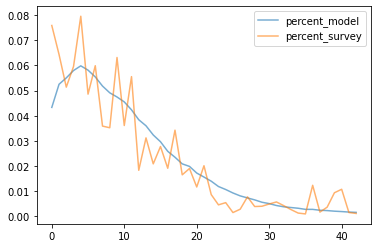

In [12]:
if len(_df_survey) > 0:
    _df_merged[['percent_model','percent_survey']].plot(alpha=0.6)
else:
    _df[['percent']].plot(alpha=0.6)

# Average Trip Distance
Workers that work DO NOT work from home

In [13]:
# Non WFH Workers
df = pd.read_csv(os.path.join(working_dir,'trip_distance_non_wfh.csv'))
df = df[df['pptyp'].isin(['Full-Time Worker','Part-Time Worker'])]
df = df[(df['dpurp'] == 'Work') & (df['dadtyp'].isin(['Other','Usual Workplace']))]
# df.groupby(['travdist_bin','']).sum()[['trexpfac']]
df_usual = df[df['dadtyp'] == 'Usual Workplace']
dist = (df_usual['trexpfac']*1.0*df_usual['travdist_bin']).sum()/df_usual['trexpfac'].sum()
print('Avg. distance to Usual Workplace: ' + str(dist))
df_other = df[df['dadtyp'] == 'Other']
dist = (df_other['trexpfac']*1.0*df_other['travdist_bin']).sum()/df_other['trexpfac'].sum()
print('Avg. distance to Other Workplace: ' + str(dist))
print('----------------------------------------')
# Non WFH Workers
df = pd.read_csv(os.path.join(working_dir,'trip_distance_non_wfh.csv'))
df['wt_sum'] = df['trexpfac']*1.0*df['travdist_bin']
result = {}
for purp in pd.unique(df['dpurp']):
    _df = df[df['dpurp'] == purp]
    result[purp] = _df['wt_sum'].sum()/_df['trexpfac'].sum()
    
_df_non_wfh = pd.DataFrame.from_dict(result, orient='index').reset_index()
_df_non_wfh.columns = ['Purpose','Workers at Non-Home Location']
_df_non_wfh

Avg. distance to Usual Workplace: 8.108870553287137
Avg. distance to Other Workplace: 4.726094232076557
----------------------------------------


,Purpose,Workers at Non-Home Location
0,None/Home,4.9091
1,Work,7.0102
2,School,3.0931
3,Escort,3.6320
4,Personal Business,3.9163
5,Shop,3.5011
6,Meal,2.6650
7,Social,4.9172
8,Change Mode Inserted Purpose,7.5339


Only workers that work **from home**

In [14]:
# WFH Workers
df = pd.read_csv(os.path.join(working_dir,'trip_distance_wfh.csv'))
df = df[(df['dpurp'] == 'Work') & (df['dadtyp'].isin(['Other','Usual Workplace']))]

df_other = df[df['dadtyp'] == 'Other']
dist = (df_other['trexpfac']*1.0*df_other['travdist_bin']).sum()/df_other['trexpfac'].sum()
print('Avg. distance to Other Workplace: ' + str(dist))
print('----------------------------------')
df = pd.read_csv(os.path.join(working_dir,'trip_distance_wfh.csv'))
df['wt_sum'] = df['trexpfac']*1.0*df['travdist_bin']
result = {}
for purp in pd.unique(df['dpurp']):
    _df = df[df['dpurp'] == purp]
    result[purp] = _df['wt_sum'].sum()/_df['trexpfac'].sum()

_df_wfh = pd.DataFrame.from_dict(result, orient='index')
_df_wfh = _df_wfh.reset_index()
_df_wfh.columns = ['Purpose','WFH Workers']
_df_wfh

Avg. distance to Other Workplace: 11.031862745098039
----------------------------------


,Purpose,WFH Workers
0,None/Home,2.6468
1,Work,11.0319
2,School,3.7909
3,Escort,1.8607
4,Personal Business,1.8973
5,Shop,1.8429
6,Meal,1.9148
7,Social,3.1832
8,Change Mode Inserted Purpose,11.1667


In [15]:
# Non-Workers
df = pd.read_csv(os.path.join(working_dir,'trip_distance_non_wfh.csv'))
df = df[-df['pptyp'].isin(['Full-Time Worker','Part-Time Worker'])]
df = df[(df['dpurp'] == 'Work') & (df['dadtyp'].isin(['Other','Usual Workplace']))]

# Non-Workers
df = pd.read_csv(os.path.join(working_dir,'trip_distance_non_wfh.csv'))
df['wt_sum'] = df['trexpfac']*1.0*df['travdist_bin']
result = {}
for purp in pd.unique(df['dpurp']):
    _df = df[df['dpurp'] == purp]
    result[purp] = _df['wt_sum'].sum()/_df['trexpfac'].sum()
    
_df_non_worker = pd.DataFrame.from_dict(result, orient='index')
_df_non_worker = _df_non_worker.reset_index()
_df_non_worker.columns = ['Purpose','Non-Workers']
_df_non_worker

,Purpose,Non-Workers
0,None/Home,4.9091
1,Work,7.0102
2,School,3.0931
3,Escort,3.6320
4,Personal Business,3.9163
5,Shop,3.5011
6,Meal,2.6650
7,Social,4.9172
8,Change Mode Inserted Purpose,7.5339


Average Trip Distance by Purpose and Worker/Person Type

In [16]:
_df = pd.merge(_df_non_wfh, _df_wfh).merge(_df_non_worker)

In [17]:
_df

,Purpose,Workers at Non-Home Location,WFH Workers,Non-Workers
0,None/Home,4.9091,2.6468,4.9091
1,Work,7.0102,11.0319,7.0102
2,School,3.0931,3.7909,3.0931
3,Escort,3.6320,1.8607,3.6320
4,Personal Business,3.9163,1.8973,3.9163
5,Shop,3.5011,1.8429,3.5011
6,Meal,2.6650,1.9148,2.6650
7,Social,4.9172,3.1832,4.9172
8,Change Mode Inserted Purpose,7.5339,11.1667,7.5339


# VMT

Workers that Work from Home

In [18]:
df = pd.read_csv(os.path.join(working_dir,'vmt_wfh.csv'))
df_survey = pd.read_csv(os.path.join(working_dir,'survey','vmt_wfh.csv'))

pd.options.display.float_format = '{:,.2f}'.format
_df = df[(df['mode'].isin(['SOV','HOV2','HOV3+']))&
   (df['dorp']==1) &
   (df['pptyp'].isin(['Full-Time Worker','Part-Time Worker']))].groupby('dpurp').sum()[['travdist_wt']]
_df['VMT per Person (Model)'] = _df['travdist_wt']/total_wfh_workers

_df_survey = df_survey[(df_survey['mode'].isin(['SOV','HOV2','HOV3+']))&
   (df_survey['dorp']==1) &
   (df_survey['pptyp'].isin(['Full-Time Worker','Part-Time Worker']))].groupby('dpurp').sum()[['travdist_wt']]
_df_survey['VMT per Person (Model)'] = _df_survey['travdist_wt']/total_wfh_workers_survey

_df = _df.merge(_df_survey, left_index=True, right_index=True, suffixes=['_model','_survey'])
_df.loc['Total',:] = _df.sum()
_df[['travdist_wt_model','travdist_wt_survey']] = _df[['travdist_wt_model','travdist_wt_survey']].astype('int')
_df.rename(columns={'travdist_wt_model': 'Total VMT (Model)', 'travidst_wt_survey': 'Total VMT (Survey)'},
                   inplace=True)
_df

,Total VMT (Model),VMT per Person (Model)_model,travdist_wt_survey,VMT per Person (Model)_survey
dpurp,,,,
Escort,118980,0.42,327609,1.17
Meal,197707,0.70,86821,0.31
None/Home,607856,2.16,1013821,3.61
Personal Business,55575,0.20,199030,0.71
School,603,0.00,371,0.00
Shop,143292,0.51,250397,0.89
Social,423148,1.51,330799,1.18
Work,8454,0.03,461596,1.64
Total,1555620,5.54,2670447,9.50


Workers that do NOT Work from Home

In [19]:
df = pd.read_csv(os.path.join(working_dir,'vmt_nonwfh.csv'))
df_survey = pd.read_csv(os.path.join(working_dir,'survey','vmt_nonwfh.csv'))

pd.options.display.float_format = '{:,.2f}'.format
_df = df[(df['mode'].isin(['SOV','HOV2','HOV3+']))&
   (df['dorp']==1) &
   (df['pptyp'].isin(['Full-Time Worker','Part-Time Worker']))].groupby('dpurp').sum()[['travdist_wt']]
_df['VMT per Person (Model)'] = _df['travdist_wt']/total_nonwfh_workers

_df_survey = df_survey[(df_survey['mode'].isin(['SOV','HOV2','HOV3+']))&
   (df_survey['dorp']==1) &
   (df_survey['pptyp'].isin(['Full-Time Worker','Part-Time Worker']))].groupby('dpurp').sum()[['travdist_wt']]
_df_survey['VMT per Person (Model)'] = _df_survey['travdist_wt']/total_nonwfh_workers_survey

_df = _df.merge(_df_survey, left_index=True, right_index=True, suffixes=['_model','_survey'])
_df.loc['Total',:] = _df.sum()
_df[['travdist_wt_model','travdist_wt_survey']] = _df[['travdist_wt_model','travdist_wt_survey']].astype('int')
_df.rename(columns={'travdist_wt_model': 'Total VMT (Model)', 'travidst_wt_survey': 'Total VMT (Survey)'},
                   inplace=True)
_df

,Total VMT (Model),VMT per Person (Model)_model,travdist_wt_survey,VMT per Person (Model)_survey
dpurp,,,,
Escort,3619719,1.66,1881137,1.01
Meal,1651892,0.76,1061734,0.57
None/Home,13064308,5.99,11845020,6.39
Personal Business,1157468,0.53,1098408,0.59
School,14016,0.01,69638,0.04
Shop,2225955,1.02,2104892,1.14
Social,3740036,1.71,2807809,1.51
Work,17597643,8.06,14448415,7.79
Total,43071040,19.74,35317057,19.05
